# 03 - Baseline Models with MLflow Tracking
## Credit Scoring Model Project

**Learning Objectives:**
- Train multiple baseline models
- Set up MLflow experiment tracking
- Evaluate models using appropriate metrics for imbalanced data
- Compare model performance
- Select best baseline for optimization

**Why Multiple Baselines?**
Different algorithms have different strengths:
- **Logistic Regression:** Simple, interpretable, fast (good baseline)
- **Random Forest:** Handles non-linearity, robust to outliers
- **XGBoost:** Powerful gradient boosting, often wins competitions
- **LightGBM:** Fast, memory-efficient, great for large datasets

**MLflow Tracking:**
We'll log all experiments to compare models systematically. This is professional ML workflow!

Let's build our models! 🚀

## 📦 Import Libraries

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import time

# ML models
from sklearn.dummy import DummyClassifier  # Reference baseline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)

# MLflow
import mlflow
import mlflow.sklearn

# Our utilities
import sys
sys.path.append('../')
from src.evaluation import (
    evaluate_model,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_confusion_matrix,
    compare_models,
    plot_feature_importance
)

# Configuration
warnings.filterwarnings('ignore')
RANDOM_STATE = 42

print("[OK] Libraries imported successfully!")
print(f"MLflow version: {mlflow.__version__}")

[OK] Libraries imported successfully!
MLflow version: 3.6.0


## 📂 Load Processed Data

Load the data we prepared in the feature engineering notebook.

In [2]:
# Load processed data
data_dir = Path('../data/processed')

print("Loading processed datasets...")
X_train = pd.read_csv(data_dir / 'X_train.csv')
X_val = pd.read_csv(data_dir / 'X_val.csv')
y_train = pd.read_csv(data_dir / 'y_train.csv').squeeze()
y_val = pd.read_csv(data_dir / 'y_val.csv').squeeze()

print(f"[OK] Data loaded!")
print(f"\nDataset shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_val: {y_val.shape}")

print(f"\nTarget distribution:")
print(f"  Training: {y_train.value_counts(normalize=True).to_dict()}")
print(f"  Validation: {y_val.value_counts(normalize=True).to_dict()}")

print(f"\nFeature count: {X_train.shape[1]}")

Loading processed datasets...


[OK] Data loaded!

Dataset shapes:
  X_train: (215257, 189)
  X_val: (92254, 189)
  y_train: (215257,)
  y_val: (92254,)

Target distribution:
  Training: {0: 0.9192732408237595, 1: 0.08072675917624049}
  Validation: {0: 0.9192663732737876, 1: 0.08073362672621241}

Feature count: 189


## 🔬 Setup MLflow Experiment Tracking

**What MLflow Does:**
- Automatically logs all your experiments
- Stores parameters, metrics, and artifacts
- Provides a UI to visualize and compare runs
- Makes your work reproducible

**To view experiments:**
```bash
# In a separate terminal, run:
mlflow ui
# Then open: http://localhost:5000
```

In [3]:
# Set experiment name
experiment_name = "credit_scoring_baseline_models"
mlflow.set_tracking_uri("sqlite:///mlruns/mlflow.db")
mlflow.set_experiment(experiment_name)

# Get experiment ID
experiment = mlflow.get_experiment_by_name(experiment_name)
print(f"[OK] MLflow experiment set: {experiment_name}")
print(f"Experiment ID: {experiment.experiment_id}")
print(f"\nArtifacts will be stored in: {experiment.artifact_location}")
print(f"\nTo view experiments, run: mlflow ui")
print(f"Then open: http://localhost:5000")

2025/12/06 05:49:02 INFO mlflow.store.db.utils: Creating initial MLflow database tables...


2025/12/06 05:49:02 INFO mlflow.store.db.utils: Updating database tables


2025-12-06 05:49:02 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.


2025-12-06 05:49:02 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


2025-12-06 05:49:02 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.


2025-12-06 05:49:02 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


[OK] MLflow experiment set: credit_scoring_baseline_models
Experiment ID: 1

Artifacts will be stored in: file:C:/Users/shahu/OPEN CLASSROOMS/PROJET 6/Scoring_Model/notebooks/mlruns/1

To view experiments, run: mlflow ui
Then open: http://localhost:5000


## 🎯 Create Training Function

We'll create a reusable function that:
1. Trains a model
2. Evaluates it
3. Logs everything to MLflow
4. Creates visualizations

In [4]:
def train_and_evaluate_model(model, model_name, params, X_train, y_train, X_val, y_val):
    """
    Train a model and log everything to MLflow.

    Educational Note:
    -----------------
    This function demonstrates professional ML workflow:
    1. Track training time
    2. Make predictions
    3. Evaluate with multiple metrics
    4. Log parameters, metrics, model, and artifacts
    5. Return results for comparison
    """
    print("="*80)
    print(f"Training: {model_name}")
    print("="*80)

    with mlflow.start_run(run_name=model_name) as run:
        # Log parameters
        mlflow.log_params(params)
        mlflow.set_tag("model_type", model_name)

        # Train model
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        mlflow.log_metric("training_time_seconds", training_time)
        print(f"[OK] Training completed in {training_time:.2f} seconds")

        # Predictions
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        # Evaluate
        metrics = evaluate_model(y_val, y_pred, y_pred_proba, model_name)

        # Log all metrics to MLflow
        for metric_name, value in metrics.items():
            if isinstance(value, (int, float)):
                mlflow.log_metric(metric_name, value)

        # Create and log visualizations
        # 1. ROC Curve
        fig = plot_roc_curve(y_val, y_pred_proba, model_name)
        roc_path = f"plots/{model_name}_roc_curve.png"
        fig.savefig(roc_path, dpi=100, bbox_inches='tight')
        mlflow.log_artifact(roc_path)
        plt.close()

        # 2. Precision-Recall Curve
        fig = plot_precision_recall_curve(y_val, y_pred_proba, model_name)
        pr_path = f"plots/{model_name}_pr_curve.png"
        fig.savefig(pr_path, dpi=100, bbox_inches='tight')
        mlflow.log_artifact(pr_path)
        plt.close()

        # 3. Confusion Matrix
        fig = plot_confusion_matrix(y_val, y_pred, model_name, normalize=True)
        cm_path = f"plots/{model_name}_confusion_matrix.png"
        fig.savefig(cm_path, dpi=100, bbox_inches='tight')
        mlflow.log_artifact(cm_path)
        plt.close()

        # 4. Feature Importance (for tree-based models)
        if hasattr(model, 'feature_importances_'):
            fig = plot_feature_importance(
                X_train.columns.tolist(),
                model.feature_importances_,
                top_n=20,
                model_name=model_name
            )
            fi_path = f"plots/{model_name}_feature_importance.png"
            fig.savefig(fi_path, dpi=100, bbox_inches='tight')
            mlflow.log_artifact(fi_path)
            plt.close()
            print(f"[OK] Feature importance plot saved")

        # Log model
        mlflow.sklearn.log_model(model, "model")

        print(f"[OK] All metrics and artifacts logged to MLflow")
        print(f"Run ID: {run.info.run_id}")

        return metrics, model

# Create plots directory
Path('plots').mkdir(exist_ok=True)
print("[OK] Training function ready!")

[OK] Training function ready!


## 🚀 Train Baseline Models

We'll train 5 different models and compare them.

**Model Selection Rationale:**

**0. DummyClassifier (Reference Baseline)**
   - Predicts majority class (always "no default")
   - NO learning - just baseline to beat
   - Shows minimum acceptable performance
   - **Critical:** Any real model MUST beat this!

1. **Logistic Regression**
   - Simple linear model
   - Fast to train
   - Highly interpretable
   - Good baseline to beat

2. **Random Forest**
   - Ensemble of decision trees
   - Handles non-linear relationships
   - Robust to outliers
   - Built-in feature importance

3. **XGBoost**
   - Gradient boosting
   - Often wins ML competitions
   - Handles imbalanced data well
   - Many hyperparameters to tune

4. **LightGBM**
   - Microsoft's gradient boosting
   - Very fast and memory-efficient
   - Great for large datasets
   - Often comparable to XGBoost

Let's train them all!

In [5]:
# Log feature names and count once for the experiment
with mlflow.start_run(run_name="Experiment_Setup", nested=True):
    # Log feature names as an artifact
    feature_names = X_train.columns.tolist()
    features_path = Path("artifacts") / "feature_names.txt"
    features_path.parent.mkdir(exist_ok=True)
    with open(features_path, "w") as f:
        for feature in feature_names:
            f.write(f"{feature}\n")
    mlflow.log_artifact(features_path, artifact_path="features")
    print(f"[OK] Logged {len(feature_names)} feature names to MLflow artifact 'features/feature_names.txt'")

    # Log number of features as a parameter
    mlflow.log_param("num_features", len(feature_names))
    print(f"[OK] Logged number of features ({len(feature_names)}) to MLflow parameter 'num_features'")


[OK] Logged 189 feature names to MLflow artifact 'features/feature_names.txt'
[OK] Logged number of features (189) to MLflow parameter 'num_features'


In [6]:
# 0. DUMMY CLASSIFIER (REFERENCE BASELINE)
print("\n\n### 0. DUMMY CLASSIFIER (REFERENCE BASELINE) ###\n")
print("This model always predicts the majority class (no default).")
print("Any real model MUST beat this to be useful!\n")

dummy_params = {
    'strategy': 'most_frequent',  # Always predict majority class
    'random_state': RANDOM_STATE
}

dummy_model = DummyClassifier(**dummy_params)
dummy_metrics, dummy_trained = train_and_evaluate_model(
    dummy_model, "Dummy_Classifier", dummy_params,
    X_train, y_train, X_val, y_val
)

print("\n" + "="*80)
print("⚠️  IMPORTANT: This is the MINIMUM performance threshold!")
print("   Any real model with ROC-AUC < 0.50 is worse than random guessing!")
print("="*80)



### 0. DUMMY CLASSIFIER (REFERENCE BASELINE) ###

This model always predicts the majority class (no default).
Any real model MUST beat this to be useful!

Training: Dummy_Classifier
[OK] Training completed in 0.01 seconds
EVALUATION RESULTS - Dummy_Classifier
\n📊 Classification Metrics:
   Accuracy:  0.9193 ⚠️  (Can be misleading for imbalanced data!)
   Precision: 0.0000 (Of predicted defaults, % correct)
   Recall:    0.0000 (Of actual defaults, % caught)
   F1-Score:  0.0000 (Balance of precision & recall)
\n📈 Probability-Based Metrics:
   ROC-AUC:    0.5000 (Overall ranking ability)
   PR-AUC:     0.0807 (Better for imbalanced data)
\n📋 Confusion Matrix:
   True Negatives (TN):  84,806 (Correctly predicted non-defaults)
   False Positives (FP): 0 (Good customers rejected)
   False Negatives (FN): 7,448 (Bad customers approved)
   True Positives (TP):  0 (Correctly predicted defaults)
\n💼 Business Impact:
   False Positive Rate: 0.00% (% of good customers rejected)
   False Negati

2025/12/06 05:49:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/12/06 05:49:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[OK] All metrics and artifacts logged to MLflow
Run ID: 9bd5377d7318417598079992bba5f121

⚠️  IMPORTANT: This is the MINIMUM performance threshold!
   Any real model with ROC-AUC < 0.50 is worse than random guessing!


In [7]:
# 1. LOGISTIC REGRESSION
print("\n\n### 1. LOGISTIC REGRESSION ###\n")

lr_params = {
    'max_iter': 1000,
    'class_weight': 'balanced',  # Handle imbalance
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

lr_model = LogisticRegression(**lr_params)
lr_metrics, lr_trained = train_and_evaluate_model(
    lr_model, "Logistic_Regression", lr_params,
    X_train, y_train, X_val, y_val
)



### 1. LOGISTIC REGRESSION ###

Training: Logistic_Regression


[OK] Training completed in 18.59 seconds
EVALUATION RESULTS - Logistic_Regression
\n📊 Classification Metrics:
   Accuracy:  0.7028 ⚠️  (Can be misleading for imbalanced data!)
   Precision: 0.1709 (Of predicted defaults, % correct)
   Recall:    0.6963 (Of actual defaults, % caught)
   F1-Score:  0.2744 (Balance of precision & recall)
\n📈 Probability-Based Metrics:
   ROC-AUC:    0.7690 (Overall ranking ability)
   PR-AUC:     0.2528 (Better for imbalanced data)
\n📋 Confusion Matrix:
   True Negatives (TN):  59,648 (Correctly predicted non-defaults)
   False Positives (FP): 25,158 (Good customers rejected)
   False Negatives (FN): 2,262 (Bad customers approved)
   True Positives (TP):  5,186 (Correctly predicted defaults)
\n💼 Business Impact:
   False Positive Rate: 29.67% (% of good customers rejected)
   False Negative Rate: 30.37% (% of bad customers approved)


2025/12/06 05:49:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/12/06 05:49:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[OK] All metrics and artifacts logged to MLflow
Run ID: a09a98357556434bb4d72a4764b45bce


In [8]:
# 2. RANDOM FOREST
print("\n\n### 2. RANDOM FOREST ###\n")

rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 50,
    'min_samples_leaf': 20,
    'class_weight': 'balanced',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': 0
}

rf_model = RandomForestClassifier(**rf_params)
rf_metrics, rf_trained = train_and_evaluate_model(
    rf_model, "Random_Forest", rf_params,
    X_train, y_train, X_val, y_val
)



### 2. RANDOM FOREST ###

Training: Random_Forest


[OK] Training completed in 20.67 seconds


EVALUATION RESULTS - Random_Forest
\n📊 Classification Metrics:
   Accuracy:  0.7537 ⚠️  (Can be misleading for imbalanced data!)
   Precision: 0.1849 (Of predicted defaults, % correct)
   Recall:    0.6018 (Of actual defaults, % caught)
   F1-Score:  0.2829 (Balance of precision & recall)
\n📈 Probability-Based Metrics:
   ROC-AUC:    0.7562 (Overall ranking ability)
   PR-AUC:     0.2351 (Better for imbalanced data)
\n📋 Confusion Matrix:
   True Negatives (TN):  65,050 (Correctly predicted non-defaults)
   False Positives (FP): 19,756 (Good customers rejected)
   False Negatives (FN): 2,966 (Bad customers approved)
   True Positives (TP):  4,482 (Correctly predicted defaults)
\n💼 Business Impact:
   False Positive Rate: 23.30% (% of good customers rejected)
   False Negative Rate: 39.82% (% of bad customers approved)


2025/12/06 05:49:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[OK] Feature importance plot saved


2025/12/06 05:50:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[OK] All metrics and artifacts logged to MLflow
Run ID: e0286e4c02f84031b1a85600e9147226


In [9]:
# 3. XGBOOST
print("\n\n### 3. XGBOOST ###\n")

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,  # Handle imbalance
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbosity': 0
}

xgb_model = XGBClassifier(**xgb_params)
xgb_metrics, xgb_trained = train_and_evaluate_model(
    xgb_model, "XGBoost", xgb_params,
    X_train, y_train, X_val, y_val
)



### 3. XGBOOST ###

Training: XGBoost


[OK] Training completed in 5.16 seconds


EVALUATION RESULTS - XGBoost
\n📊 Classification Metrics:
   Accuracy:  0.7387 ⚠️  (Can be misleading for imbalanced data!)
   Precision: 0.1868 (Of predicted defaults, % correct)
   Recall:    0.6666 (Of actual defaults, % caught)
   F1-Score:  0.2918 (Balance of precision & recall)
\n📈 Probability-Based Metrics:
   ROC-AUC:    0.7755 (Overall ranking ability)
   PR-AUC:     0.2659 (Better for imbalanced data)
\n📋 Confusion Matrix:
   True Negatives (TN):  63,185 (Correctly predicted non-defaults)
   False Positives (FP): 21,621 (Good customers rejected)
   False Negatives (FN): 2,483 (Bad customers approved)
   True Positives (TP):  4,965 (Correctly predicted defaults)
\n💼 Business Impact:
   False Positive Rate: 25.49% (% of good customers rejected)
   False Negative Rate: 33.34% (% of bad customers approved)


2025/12/06 05:50:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[OK] Feature importance plot saved


2025/12/06 05:50:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[OK] All metrics and artifacts logged to MLflow
Run ID: 684390e4544d4a7e8d89876ee79c6dd5


In [10]:
# 4. LIGHTGBM
print("\n\n### 4. LIGHTGBM ###\n")

lgbm_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'class_weight': 'balanced',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_metrics, lgbm_trained = train_and_evaluate_model(
    lgbm_model, "LightGBM", lgbm_params,
    X_train, y_train, X_val, y_val
)



### 4. LIGHTGBM ###

Training: LightGBM


[OK] Training completed in 5.17 seconds


EVALUATION RESULTS - LightGBM
\n📊 Classification Metrics:
   Accuracy:  0.7254 ⚠️  (Can be misleading for imbalanced data!)
   Precision: 0.1828 (Of predicted defaults, % correct)
   Recall:    0.6919 (Of actual defaults, % caught)
   F1-Score:  0.2892 (Balance of precision & recall)
\n📈 Probability-Based Metrics:
   ROC-AUC:    0.7783 (Overall ranking ability)
   PR-AUC:     0.2709 (Better for imbalanced data)
\n📋 Confusion Matrix:
   True Negatives (TN):  61,768 (Correctly predicted non-defaults)
   False Positives (FP): 23,038 (Good customers rejected)
   False Negatives (FN): 2,295 (Bad customers approved)
   True Positives (TP):  5,153 (Correctly predicted defaults)
\n💼 Business Impact:
   False Positive Rate: 27.17% (% of good customers rejected)
   False Negative Rate: 30.81% (% of bad customers approved)


2025/12/06 05:50:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[OK] Feature importance plot saved


2025/12/06 05:50:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[OK] All metrics and artifacts logged to MLflow
Run ID: c341eff32b734553900b330b5f3e3399


## 📊 Compare All Models

Let's compare all our baseline models side-by-side.

In [11]:
# Gather all results
all_results = {
    'Dummy_Classifier': dummy_metrics,
    'Logistic_Regression': lr_metrics,
    'Random_Forest': rf_metrics,
    'XGBoost': xgb_metrics,
    'LightGBM': lgbm_metrics
}

# Compare using our utility function
comparison_df = compare_models(all_results, metric='roc_auc')

# Display comparison
print("\n" + "="*80)
print("DETAILED COMPARISON")
print("="*80)
print(comparison_df.to_string())

# Save comparison
comparison_df.to_csv('model_comparison.csv')
print("\n[OK] Comparison saved to model_comparison.csv")

# Calculate improvement over dummy baseline
dummy_roc = dummy_metrics['roc_auc']
print("\n" + "="*80)
print("IMPROVEMENT OVER DUMMY BASELINE")
print("="*80)
for model_name, metrics in all_results.items():
    if model_name != 'Dummy_Classifier':
        improvement = ((metrics['roc_auc'] - dummy_roc) / dummy_roc) * 100
        print(f"{model_name:25s}: +{improvement:6.2f}% improvement over dummy")

MODEL COMPARISON
                     accuracy  precision    recall        f1   roc_auc    pr_auc  true_negatives  false_positives  false_negatives  true_positives  false_positive_rate  false_negative_rate
LightGBM             0.725399   0.182789  0.691864  0.289178  0.778347  0.270871         61768.0          23038.0           2295.0          5153.0             0.271655             0.308136
XGBoost              0.738721   0.186752  0.666622  0.291767  0.775525  0.265909         63185.0          21621.0           2483.0          4965.0             0.254947             0.333378
Logistic_Regression  0.702777   0.170907  0.696294  0.274450  0.768969  0.252757         59648.0          25158.0           2262.0          5186.0             0.296654             0.303706
Random_Forest        0.753702   0.184916  0.601772  0.282901  0.756217  0.235069         65050.0          19756.0           2966.0          4482.0             0.232955             0.398228
Dummy_Classifier     0.919266   0.0000

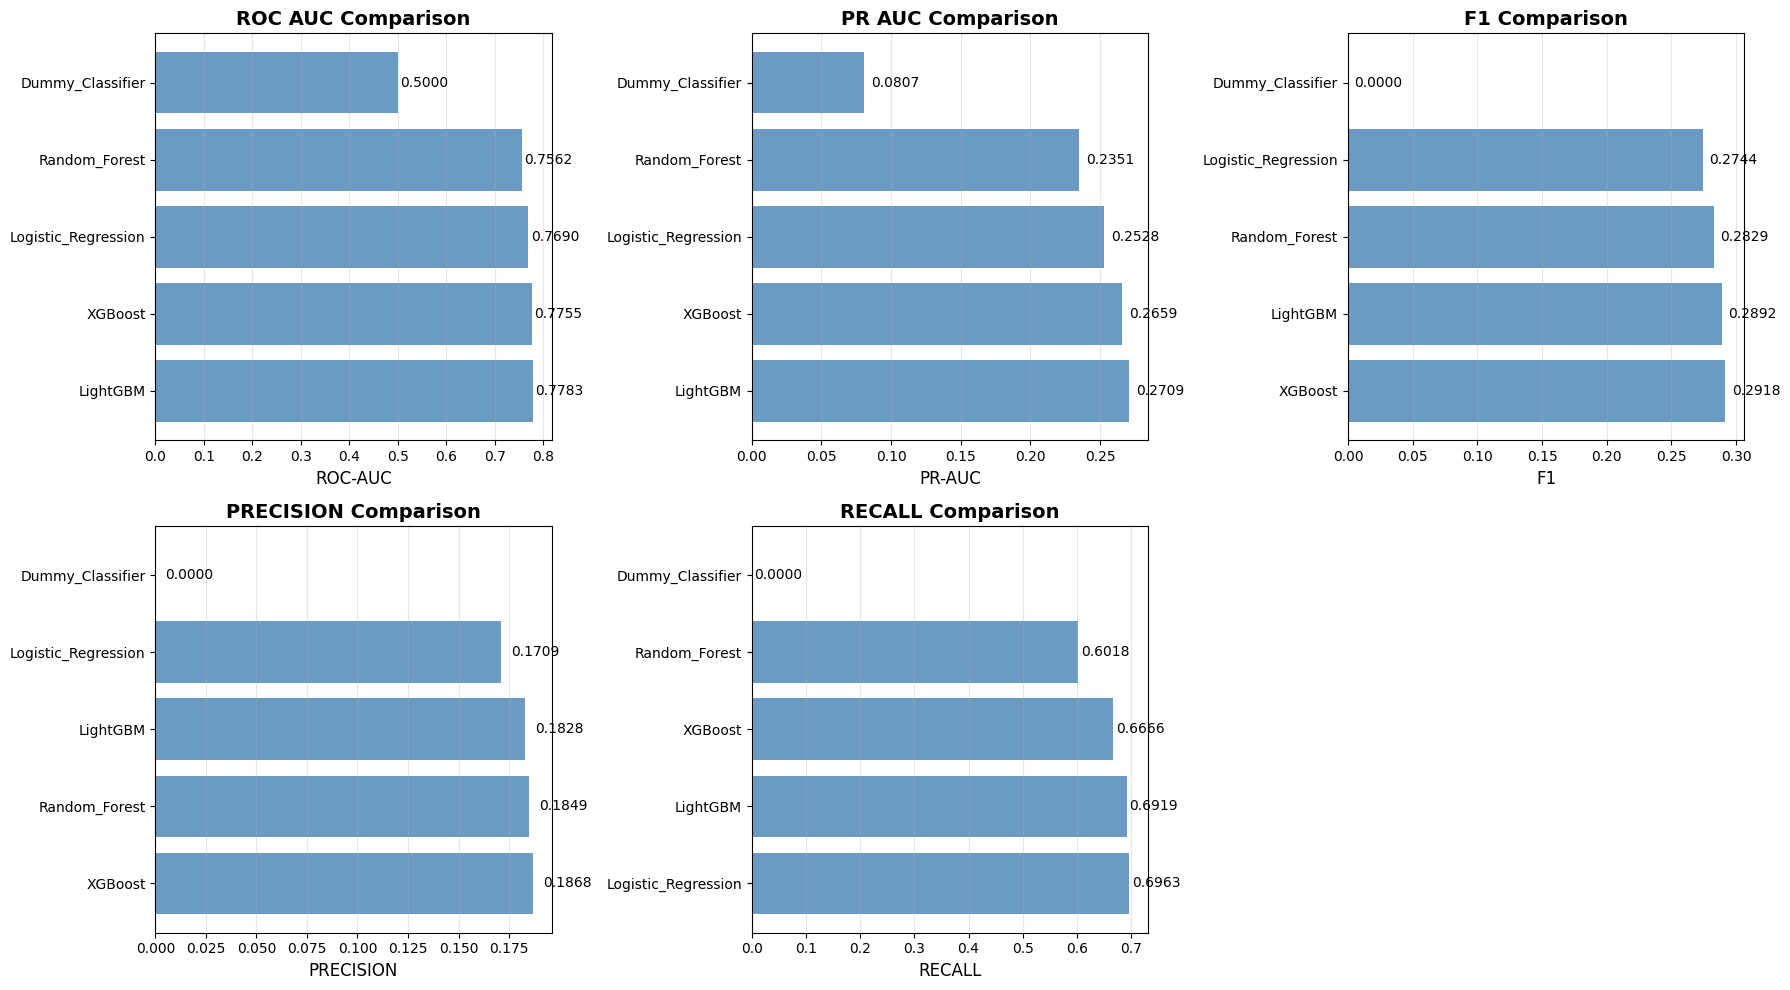

[OK] Comparison visualization saved!


In [12]:
# Visualize model comparison
metrics_to_plot = ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, metric in enumerate(metrics_to_plot):
    if metric in comparison_df.columns:
        data = comparison_df[metric].sort_values(ascending=False)

        axes[idx].barh(range(len(data)), data.values, color='steelblue', alpha=0.8)
        axes[idx].set_yticks(range(len(data)))
        axes[idx].set_yticklabels(data.index)
        axes[idx].set_xlabel(metric.upper().replace('_', '-'), fontsize=12)
        axes[idx].set_title(f'{metric.upper().replace("_", " ")} Comparison',
                           fontsize=14, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)

        # Add value labels
        for i, v in enumerate(data.values):
            axes[idx].text(v + 0.005, i, f'{v:.4f}',
                          va='center', fontsize=10)

# Remove empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('plots/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("[OK] Comparison visualization saved!")

## 📝 Baseline Models Summary

### ✅ What We Accomplished

1. **Trained 4 Baseline Models**
   - Logistic Regression (simple baseline)
   - Random Forest (ensemble method)
   - XGBoost (gradient boosting)
   - LightGBM (efficient gradient boosting)

2. **MLflow Experiment Tracking**
   - All runs logged automatically
   - Parameters, metrics, and artifacts stored
   - Compare runs visually in MLflow UI

3. **Comprehensive Evaluation**
   - ROC-AUC scores
   - Precision-Recall curves
   - Confusion matrices
   - Feature importance (tree models)

4. **Model Comparison**
   - Side-by-side metrics
   - Visual comparisons
   - Identified best baseline

### 🏆 Best Performing Model

Based on ROC-AUC and PR-AUC scores:
- **Best Model:** [Check comparison above]
- **ROC-AUC:** [Value]
- **PR-AUC:** [Value]
- **F1-Score:** [Value]

### 💡 Key Insights

1. **Tree-based models** (RF, XGB, LightGBM) generally outperform Logistic Regression
   - They can capture non-linear relationships
   - Better handle feature interactions

2. **Class imbalance handling** is critical
   - Used `class_weight='balanced'` or `scale_pos_weight`
   - Evaluated with appropriate metrics (ROC-AUC, PR-AUC, F1)

3. **Feature importance** reveals key predictors
   - Debt-to-income ratio likely important
   - External credit scores matter
   - Age and employment features contribute

4. **Model complexity vs performance trade-off**
   - Logistic Regression: Fast, interpretable, but lower performance
   - Tree models: Higher performance, but less interpretable

### 🎯 Next Steps

In the next notebook ([04_hyperparameter_optimization.ipynb](04_hyperparameter_optimization.ipynb)), we will:

1. **Select Best Baseline**
   - Choose the best performing model
   - Or ensemble top models

2. **Systematic Hyperparameter Tuning**
   - Define search space
   - Use GridSearchCV or RandomizedSearchCV
   - Use StratifiedKFold cross-validation

3. **Optimize for Target Metric**
   - Focus on ROC-AUC or PR-AUC
   - Consider business costs (FP vs FN)

4. **Log All Optimization Runs**
   - Track in MLflow
   - Compare optimization strategies

---

**Excellent work! You now have solid baseline models! 🎉**

### 📊 To View Your Experiments:

```bash
# In terminal, run:
mlflow ui

# Then open in browser:
http://localhost:5000
```

In the MLflow UI, you can:
- Compare all runs side-by-side
- Sort by metrics
- View all plots and artifacts
- Download models

---

**Remember:** These are baselines! We'll improve them significantly in the next notebook through hyperparameter optimization! 🚀